## Temperature Tendency Analysis

Here, I analyse a simulation where I hacked the Isca code, so it output useful tendency information.

Some diagnostics are different for this simulation. All have units of *K/s*:
* `dt_vg_diffusion`: Total temperature tendency before any diffusion calculation (basically just `dt_tg_convection` + `tdt_rad`).
* `dt_ug_diffusion`: Total temperature tendency after downward diffusion, but before upward diffusion. This is very similar to the above tendency as downward diffusion does not have much effect.
* `dt_tg_diffusion`: Total temperature tendency after all diffusion calculations. This differs near the surface to the above.
* `ucomp`: Total temperature tendency after both horizontal and vertical advection and `four_in_one` function. Basically after `spectral_dynamics`.
* `vcomp`: Total temperature tendency after the leapfrog procedure. I.e. this is `(temp(future)-temp(current))/time_step`.

In addition, I changed `delta_t_surf` so units are *K/s* rather than *K*, for ease of comparison. But still gives temperature tendency of the surface.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-03-25 17:43:55,707 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [35]:
exp_dir = 'play/temp_tendency/'
tau_lw_ref = 1
tau_lw_hot = 3.5
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_hot).replace('.','_')}"]
# exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_ref).replace('.','_')}_no_conv"]
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_ref).replace('.','_')}_short"]
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_ref).replace('.','_')}_new"]
exp_names = ['k=3_5_radtime=0_1', 'k=3_5_radtime=10']
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []

# use_time_start = 360*2
use_time_start = 0      # because little data
# use_time_end = np.inf
use_time_end = 30        # just consider first day
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    ds_base += [ds_use.sel(time=slice(use_time_start, use_time_end))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

In [36]:
# Load in dataset with surface and free troposphere across all latitudes, for given season

# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40  # should be 40, but saving memory
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 80
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
use_summer = False      # if true, will set ds will only contain summer months. Do this outside tropics

ds = []  # need both all and summer day dataset
lat_use_ind = np.where((np.abs(ds_base[0].lat) <= lat_max) & (np.abs(ds_base[0].lat) >= lat_min))[0]
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i]
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds += [ds_use.isel(lat=lat_use_ind).load()]
        pbar.update(1)
p_surface = float(ds[0].pfull[-1]) * 100
n_lat = ds[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds[0].lat))     # latitude area weighting is just the cosine

100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


## Hottest Day

Here I take a single day, which is the hottest day in the region, and look at it in detail, to see why it deviates from the temperature profile we expect if it was convectively neutral.

In [37]:
max_surf_temp_ind = [ds[i].temp[-1].argmax(dim=['lat', 'lon_time']) for i in range(n_exp)]
# max_surf_temp_ind = ds[0].vcomp[-1].argmax(dim=['lat', 'lon_time'])      # large temp tendency
# max_surf_temp_ind[0]['lat'] = 9
# max_surf_temp_ind[0]['lon_time'] = 32
ds_hot_day = [ds[i].isel(lat=int(max_surf_temp_ind[i]['lat']), lon_time=int(max_surf_temp_ind[i]['lon_time'])) for i in range(n_exp)]
# ds_hot_day_next = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+1)
# ds_hot_day = ds_base[0].isel(time=33, lon=34, lat=21).load()
# ds_hot_day_next = ds_base[0].isel(time=32, lon=34, lat=21).load()
# SANITY CHECK - check first time to see if tem tendency makes sense as leapfrog easy to understand for first time step
ds_hot_day = [ds[i].isel(lat=9, lon_time=22) for i in range(n_exp)]    

In [38]:
# For check particular simulations
# ds_use = isca_tools.load_dataset(exp_dir + 'k=1_taubm=120000')
# ds_use = ds_use.isel(time=23, lon=39, lat=26)

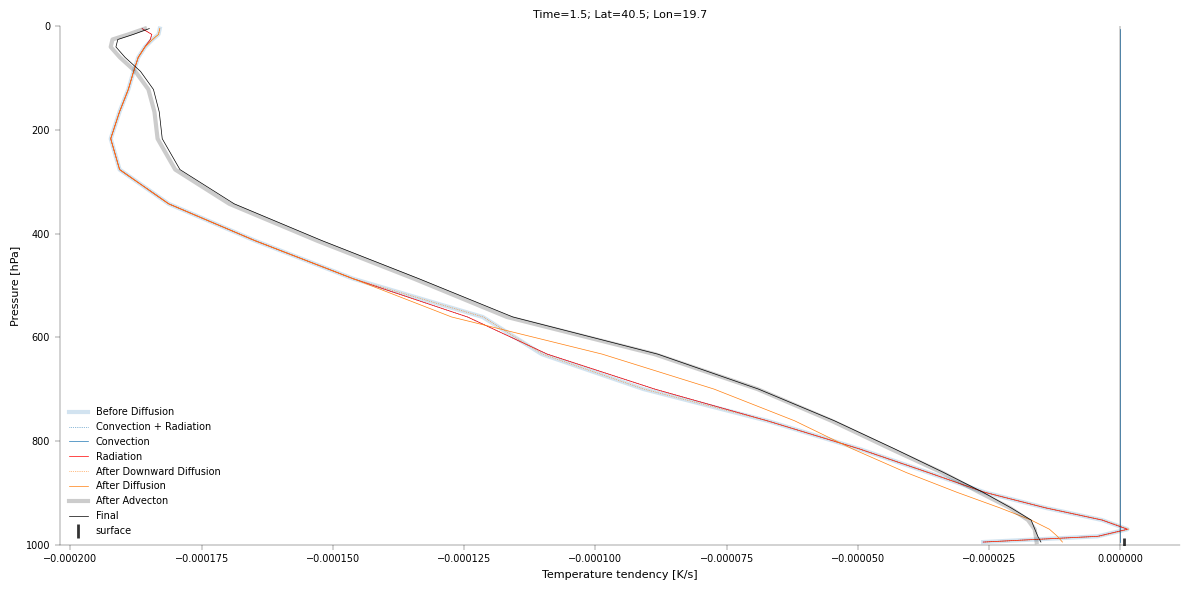

In [41]:
colors_tend = {'convection': default_colors[0], 'radiation': 'r', 'diffusion': default_colors[1], 'advection': default_colors[2]}
ds_use = ds_hot_day[1]
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(ds_use.dt_vg_diffusion, ds_use.pfull, label='Before Diffusion', color=colors_tend['convection'], lw=3, alpha=0.2)
ax.plot(ds_use.tdt_rad+ds_use.dt_tg_convection, ds_use.pfull, label='Convection + Radiation', color=colors_tend['convection'],
        linestyle=':')
ax.plot(ds_use.dt_tg_convection, ds_use.pfull, label='Convection', color=colors_tend['convection'])
ax.plot(ds_use.tdt_rad, ds_use.pfull, label='Radiation', color=colors_tend['radiation'])
ax.plot(ds_use.dt_ug_diffusion, ds_use.pfull, label='After Downward Diffusion', color=colors_tend['diffusion'], linestyle=':')
ax.plot(ds_use.dt_tg_diffusion, ds_use.pfull, label='After Diffusion', color=colors_tend['diffusion'])
ax.plot(ds_use.ucomp, ds_use.pfull, label='After Advecton', color='k', lw=3, alpha=0.2)
ax.plot(ds_use.vcomp, ds_use.pfull, label='Final', color='k')
ax.scatter(ds_use.delta_t_surf, 1000, marker='|', s=90, color='k', lw=2, alpha=0.8, label='surface')
ax.invert_yaxis()
ax.legend()
ax.set_ylim(1000, 0)
ax.axvline(0, color='k', lw=ax_linewidth)
# ax.set_xlim(-6e-5, 6e-5)
ax.set_title(f'Time={float(ds_use.time)}; Lat={round(float(ds_use.lat), 1)}; Lon={round(float(ds_use.lon), 1)}')
ax.set_xlabel('Temperature tendency [K/s]')
ax.set_ylabel('Pressure [hPa]')
plt.tight_layout()

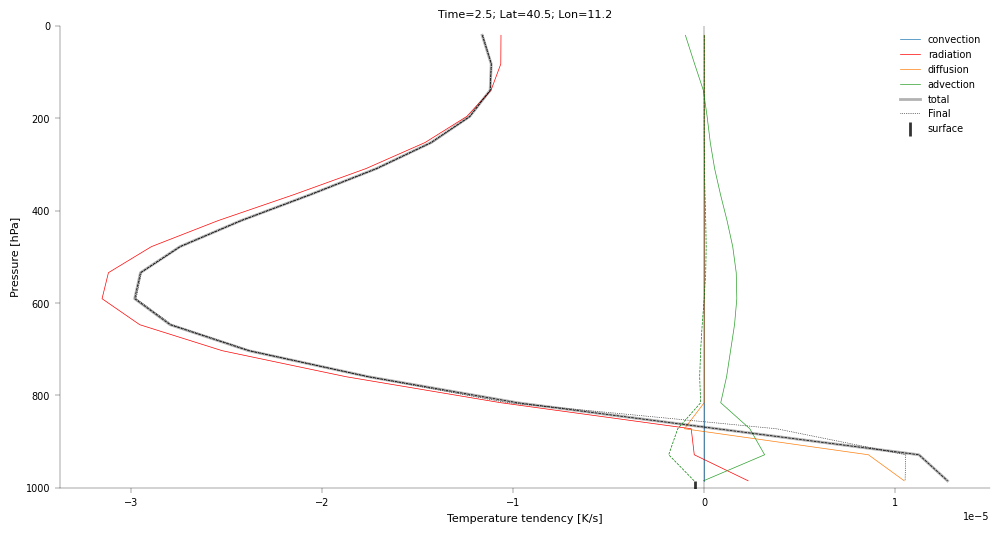

In [20]:
save_temp_tend_fig = False
tend_conv = ds_use.dt_tg_convection
tend_rad = ds_use.tdt_rad
tend_diffusion = ds_use.dt_tg_diffusion - ds_use.dt_vg_diffusion
tend_advection = ds_use.ucomp - ds_use.dt_tg_diffusion
if save_temp_tend_fig:
    fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
else:
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(tend_conv, ds_use.pfull, color=colors_tend['convection'], label='convection')
ax.plot(tend_rad, ds_use.pfull, color=colors_tend['radiation'], label='radiation')
ax.plot(tend_diffusion, ds_use.pfull, color=colors_tend['diffusion'], label='diffusion')
ax.plot(tend_advection, ds_use.pfull, color=colors_tend['advection'], label='advection')
ax.plot(tend_conv+tend_rad+tend_diffusion+tend_advection, ds_use.pfull, color='k', lw=2, alpha=0.3, label='total')
ax.plot(ds_use.ucomp, ds_use.pfull, color='k', linestyle='--')
ax.plot(ds_use.omega, ds_use.pfull, color='green', linestyle='--')
ax.plot(ds_use.vcomp, ds_use.pfull, color='k', linestyle=':', label='Final')
ax.scatter(ds_use.delta_t_surf, 1000, marker='|', s=90, color='k', lw=2, alpha=0.8, label='surface')
ax.invert_yaxis()
ax.legend()
ax.set_ylim(1000, 0)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.set_title(f'Time={float(ds_use.time)}; Lat={round(float(ds_use.lat), 1)}; Lon={round(float(ds_use.lon), 1)}')
ax.set_xlabel('Temperature tendency [K/s]')
ax.set_ylabel('Pressure [hPa]')

if save_fig or save_temp_tend_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_tend_breakdown.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [321]:
ds_hot_day[0].dt_tg_diffusion - ds_hot_day[1].dt_tg_diffusion

<xarray.DataArray 'omega' (pfull: 25)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
    time     float64 0.5
    lon      float64 0.0
    lat      float64 40.46
  * pfull    (pfull) float64 4.329 15.55 25.36 39.73 ... 952.4 970.2 983.8 994.9

In [245]:
# Reduce to just surface and FT
pressure_ft = 500
ind_surf = 0
ind_ft = 1
n_pressure = 2
if ds[0].pfull.size > n_pressure:
    ds = [ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest') for i in range(n_exp)]
    pressure_ft_actual = float(ds[0].pfull[ind_ft] * 100)

In [222]:
# Get values averaged around a surface temperature percentile, rather than exactly on it.
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
quant3_method = 'temp'            # Take percentile to be temperature percentile      (this is legacy, what I was doing previously)
# quant3_method = 'mse'             # Take percentile to be of near-surface mse (think this is correct version of theory)
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant)) 
temp_mean = np.zeros((n_exp, n_pressure, n_lat))   
# In free troposphere, this is saturated MSE.
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))  
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant))
temp_tend_quant3 = {'convection': np.zeros((n_exp, n_pressure, n_lat, n_quant)), 
                    'radiation': np.zeros((n_exp, n_pressure, n_lat, n_quant)),
                    'diffusion': np.zeros((n_exp, n_pressure, n_lat, n_quant)),
                    'advection': np.zeros((n_exp, n_pressure, n_lat, n_quant))}
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant))
klzb_quant3 = np.zeros((n_exp, n_lat, n_quant))
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds[i].temp[0], ds[i].sphum[0], ds[i].height[0])
        mse_ft = moist_static_energy(ds[i].temp[-1], sphum_sat(ds[i].temp[-1], pressure_ft_actual), ds[i].height[-1])
        mse_mean[i, 0] = mse.mean(dim='lon_time')
        mse_mean[i, 1] = mse_ft.mean(dim='lon_time')
        temp_mean[i] = ds[i].temp.mean(dim='lon_time')
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                if quant3_method == 'temp':
                    use_ind = get_quant_ind(ds[i].temp[0, k], quant, 0.5, 0.5)
                elif quant3_method == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                temp_quant3[i, :, k, j] = ds[i].temp[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 0, k, j] = mse[k, use_ind].mean(dim='lon_time')           # this is the same as mse_quant2 if quant3_type == mse
                mse_quant3[i, 1, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                sphum_quant3[i, k, j] = ds[i].sphum[ind_surf, k, use_ind].mean(dim='lon_time')     # 0 means surface
                convflag_quant3[i, k, j] = ds[i].convflag[k, use_ind].mean(dim='lon_time', skipna=True)
                klzb_quant3[i, k, j] = ds[i].klzbs[k, use_ind].mean(dim='lon_time', skipna=True)
                temp_tend_quant3['convection'][i, :, k, j] = ds[i].dt_tg_convection[:, k, use_ind].mean(dim='lon_time', skipna=True)
                temp_tend_quant3['radiation'][i, :, k, j] = ds[i].tdt_rad[:, k, use_ind].mean(dim='lon_time', skipna=True)
                temp_tend_quant3['diffusion'][i, :, k, j] = (ds[i].dt_tg_diffusion - 
                                                             ds[i].dt_vg_diffusion)[:, k, use_ind].mean(dim='lon_time', skipna=True)
                temp_tend_quant3['advection'][i, :, k, j] = (ds[i].ucomp - 
                                                             ds[i].dt_tg_diffusion)[:, k, use_ind].mean(dim='lon_time', skipna=True)
                pbar.update(1)

 21%|██        | 376/1782 [00:01<00:06, 218.29it/s]

KeyboardInterrupt



In [204]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds_base[0].pfull)), ds_base[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

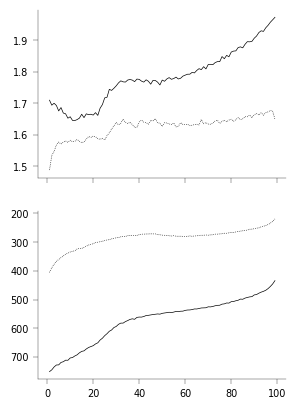

In [205]:
linestyles = ['-', ':']
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(convflag_quant3[i], axis=0, weights=lat_weights),
            color='k', linestyle=linestyles[i])
    ax[1].plot(quant_plot, lzb(np.average(klzb_quant3[i], axis=0, weights=lat_weights)),
            color='k', linestyle=linestyles[i])
ax[1].invert_yaxis()

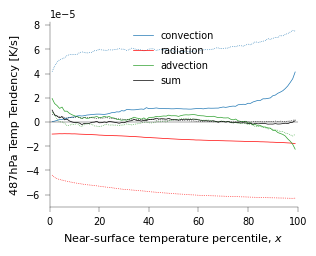

In [206]:
save_temp_tend_quant_fig = True
if save_temp_tend_quant_fig:
    fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
else:
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax = [ax]
for i in range(n_exp):
    for key in temp_tend_quant3:
        for j in [ind_ft]:
            if key == 'diffusion' and j==ind_ft:
                continue
            ax[0].plot(quant_plot, np.average(temp_tend_quant3[key][i, j], axis=0, weights=lat_weights),
                       color=colors_tend[key], label=key if i==0 else None, linestyle=linestyles[i])
    ax[0].plot(quant_plot, np.average(np.sum(np.asarray([temp_tend_quant3[key][i, j] for key in temp_tend_quant3]), axis=0), 
                                      axis=0, weights=lat_weights),
               color='k', label='sum' if i==0 else None, linestyle=linestyles[i])
ax[0].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlabel('Near-surface temperature percentile, $x$')
# fig.supylabel('Temperature tendency [K/s]', fontsize=7)
# ax[0].set_title('Near-surface')
ax[0].set_ylabel(f'{int(round(pressure_ft_actual/100, 0))}hPa Temp Tendency [K/s]')
ax[0].set_xlim(0, 100)
if save_fig or save_temp_tend_quant_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_tend_quant_{region}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)